[*********************100%***********************]  1 of 1 completed

Fetching Ethereum data...
Dataframe columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
Last available month: 2025-02
Calculating technical indicators...



<ipython-input-19-44fd9388f798>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data.resample('M', on='Date').agg({


Preprocessing data...
Training model and predicting next month...


<ipython-input-19-44fd9388f798>:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)


Model Training Accuracy: 1.00
Generating historical plots...


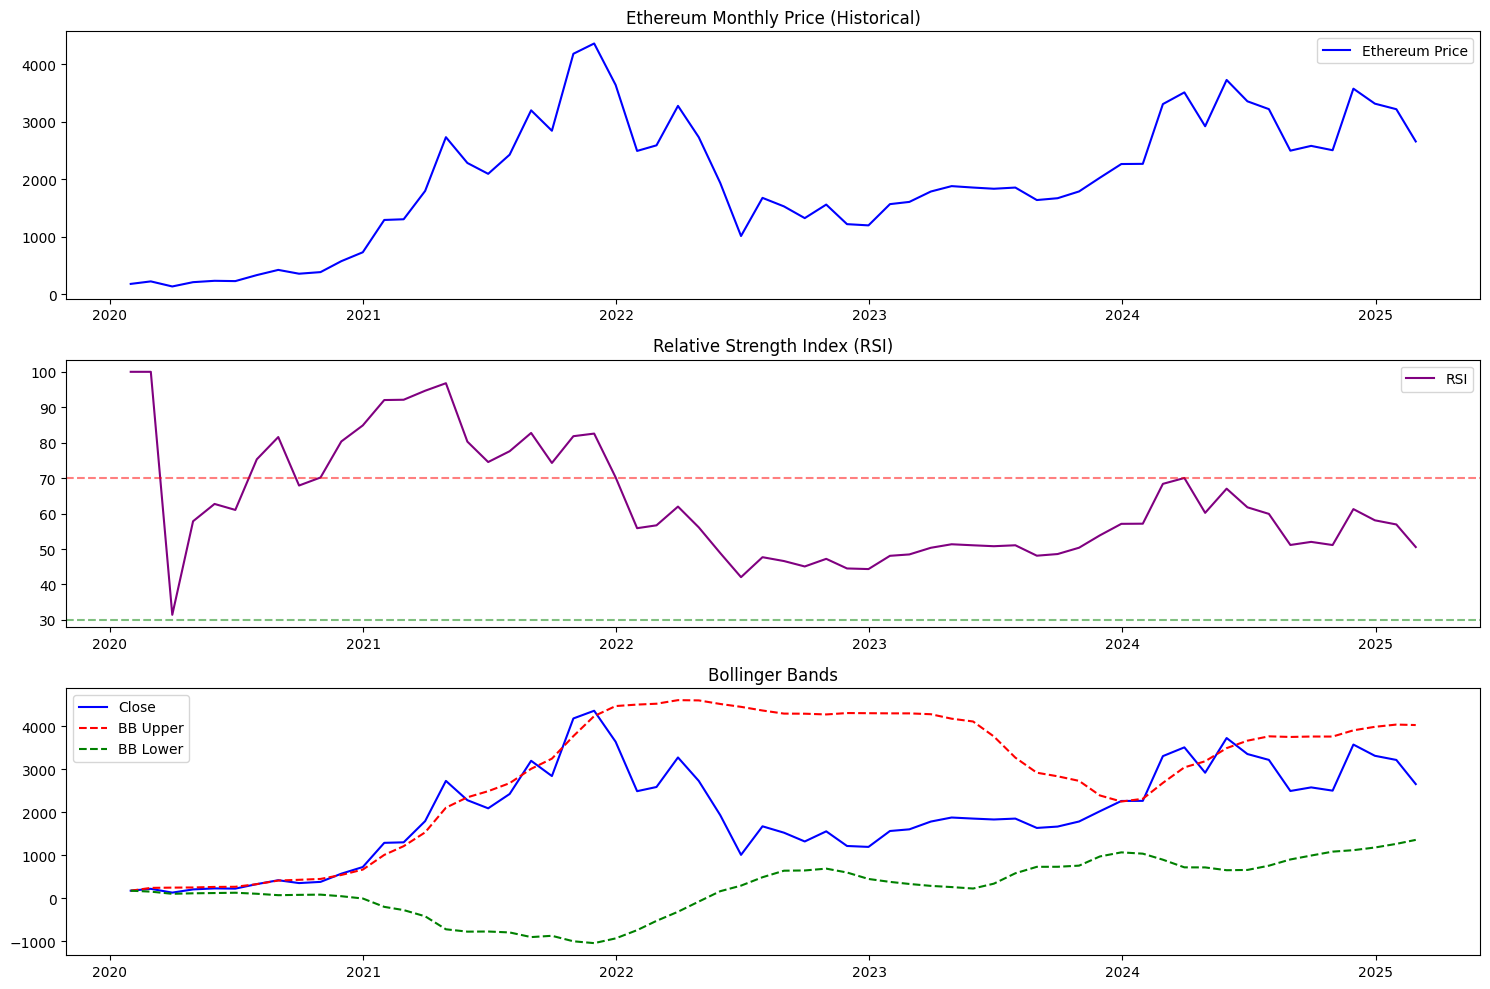

Analyzing indicators...

Prediction for Next Month (March 2025): Downtrend
Indicator Analysis based on Last Month's Data:
MACD: downtrend (1.57% importance)
RSI: neutral (0.61% importance)
SMA_20: downtrend (1.89% importance)
EMA_20: downtrend (2.07% importance)
BB: within bands (0.00% importance)


In [19]:
# Step 1: Import Libraries and Setup
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from ta import add_all_ta_features
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime

# Step 2: Fetch Ethereum Data (Monthly)
def fetch_ethereum_data():
    ticker = "ETH-USD"
    start_date = "2020-01-01"
    end_date = datetime.today().strftime('%Y-%m-%d')  # Up to Feb 23, 2025
    data = yf.download(ticker, start=start_date, end=end_date, interval="1d", auto_adjust=False)
    data = data.reset_index()
    data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    data['Date'] = pd.to_datetime(data['Date'])
    monthly_data = data.resample('M', on='Date').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum',
        'Adj Close': 'last'
    }).reset_index()
    return monthly_data

# Step 3: Calculate Technical Indicators
def calculate_indicators(df):
    required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in required_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        else:
            raise KeyError(f"Column '{col}' not found in dataframe")

    df = add_all_ta_features(
        df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
    )

    df['SMA_20'] = SMAIndicator(close=df['Close'], window=20, fillna=True).sma_indicator()
    df['EMA_20'] = EMAIndicator(close=df['Close'], window=20, fillna=True).ema_indicator()
    df['RSI'] = RSIIndicator(close=df['Close'], window=14, fillna=True).rsi()
    bb = BollingerBands(close=df['Close'], window=20, window_dev=2, fillna=True)
    df['BB_upper'] = bb.bollinger_hband()
    df['BB_lower'] = bb.bollinger_lband()
    macd = MACD(close=df['Close'], fillna=True)
    df['MACD'] = macd.macd()
    df['MACD_signal'] = macd.macd_signal()

    return df

# Step 4: Preprocess Data and Prepare for Prediction
def preprocess_data(df):
    # Define target: 1 if next month's close is higher, 0 if lower
    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
    # Separate training data (all but last row) and prediction data (last row)
    train_df = df.iloc[:-1].dropna()  # Drop NaN from shift
    last_row = df.iloc[-1:]  # Last month for prediction
    # Features exclude Date, OHLCV, Adj Close, and Target
    feature_cols = [col for col in df.columns if col not in ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Target']]
    X_train = train_df[feature_cols]
    y_train = train_df['Target']
    X_last = last_row[feature_cols]
    return X_train, y_train, X_last, df

# Step 5: Train Model and Predict Next Month
def train_and_predict(X_train, y_train, X_last):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    # Validate model accuracy on training data (since we don't split further)
    y_pred_train = model.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred_train)
    print(f"Model Training Accuracy: {accuracy:.2f}")
    # Predict next month
    next_month_pred = model.predict(X_last)[0]
    feature_importance = pd.Series(model.feature_importances_, index=X_train.columns)
    return next_month_pred, feature_importance

# Step 6: Visualize Historical Data
def plot_results(df):
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    plt.plot(df['Date'], df['Close'], label='Ethereum Price', color='blue')
    plt.title('Ethereum Monthly Price (Historical)')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(df['Date'], df['RSI'], label='RSI', color='purple')
    plt.axhline(70, color='red', linestyle='--', alpha=0.5)
    plt.axhline(30, color='green', linestyle='--', alpha=0.5)
    plt.title('Relative Strength Index (RSI)')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(df['Date'], df['Close'], label='Close', color='blue')
    plt.plot(df['Date'], df['BB_upper'], label='BB Upper', color='red', linestyle='--')
    plt.plot(df['Date'], df['BB_lower'], label='BB Lower', color='green', linestyle='--')
    plt.title('Bollinger Bands')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Step 7: Analyze Indicators for Next Month Prediction
def analyze_indicators(df, feature_importance, next_month_pred):
    latest = df.iloc[-1]
    indicators = {
        'MACD': 'uptrend' if latest['MACD'] > latest['MACD_signal'] else 'downtrend',
        'RSI': 'overbought' if latest['RSI'] > 70 else 'oversold' if latest['RSI'] < 30 else 'neutral',
        'SMA_20': 'uptrend' if latest['Close'] > latest['SMA_20'] else 'downtrend',
        'EMA_20': 'uptrend' if latest['Close'] > latest['EMA_20'] else 'downtrend',
        'BB': 'above upper' if latest['Close'] > latest['BB_upper'] else 'below lower' if latest['Close'] < latest['BB_lower'] else 'within bands'
    }

    total_importance = feature_importance.sum()
    print(f"\nPrediction for Next Month (March 2025): {'Uptrend' if next_month_pred == 1 else 'Downtrend'}")
    print("Indicator Analysis based on Last Month's Data:")
    for indicator, trend in indicators.items():
        importance = feature_importance.get(indicator, 0) / total_importance * 100
        print(f"{indicator}: {trend} ({importance:.2f}% importance)")

# Main Execution
def main():
    print("Fetching Ethereum data...")
    df = fetch_ethereum_data()
    print("Dataframe columns:", df.columns.tolist())
    print(f"Last available month: {df['Date'].iloc[-1].strftime('%Y-%m')}")

    print("Calculating technical indicators...")
    df = calculate_indicators(df)

    print("Preprocessing data...")
    X_train, y_train, X_last, df = preprocess_data(df)

    print("Training model and predicting next month...")
    next_month_pred, feature_importance = train_and_predict(X_train, y_train, X_last)

    print("Generating historical plots...")
    plot_results(df)

    print("Analyzing indicators...")
    analyze_indicators(df, feature_importance, next_month_pred)

if __name__ == "__main__":
    main()

[*********************100%***********************]  1 of 1 completed

Fetching Bitcoin data...
Dataframe columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
Last available month: 2025-02
Calculating technical indicators...



<ipython-input-20-79331accbfa4>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data.resample('M', on='Date').agg({


Preprocessing data...
Training model and predicting next month...


<ipython-input-20-79331accbfa4>:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)


Model Training Accuracy: 1.00
Generating historical plots...


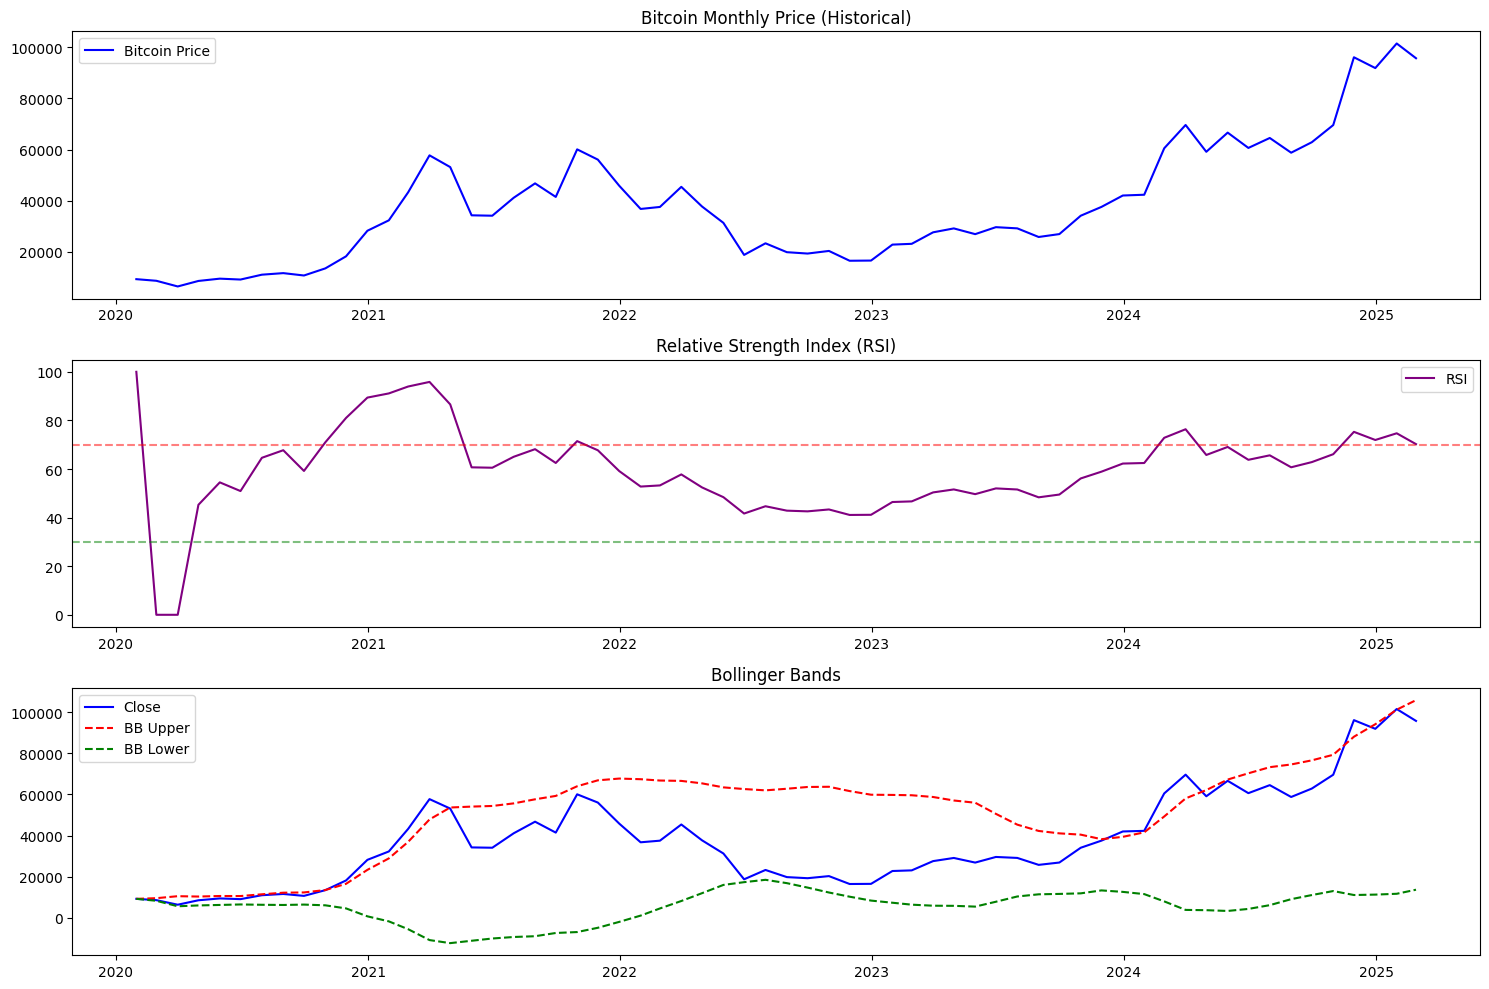

Analyzing indicators...

Prediction for Next Month (March 2025): Downtrend
Indicator Analysis based on Last Month's Data:
MACD: uptrend (1.36% importance)
RSI: overbought (1.03% importance)
SMA_20: uptrend (0.87% importance)
EMA_20: uptrend (0.88% importance)
BB: within bands (0.00% importance)


In [20]:
# Step 1: Import Libraries and Setup
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from ta import add_all_ta_features
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime

# Step 2: Fetch Bitcoin Data (Monthly)
def fetch_bitcoin_data():
    ticker = "BTC-USD"  # Changed to Bitcoin
    start_date = "2020-01-01"
    end_date = datetime.today().strftime('%Y-%m-%d')  # Up to Feb 23, 2025
    data = yf.download(ticker, start=start_date, end=end_date, interval="1d", auto_adjust=False)
    data = data.reset_index()
    data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    data['Date'] = pd.to_datetime(data['Date'])
    monthly_data = data.resample('M', on='Date').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum',
        'Adj Close': 'last'
    }).reset_index()
    return monthly_data

# Step 3: Calculate Technical Indicators
def calculate_indicators(df):
    required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in required_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        else:
            raise KeyError(f"Column '{col}' not found in dataframe")

    df = add_all_ta_features(
        df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
    )

    df['SMA_20'] = SMAIndicator(close=df['Close'], window=20, fillna=True).sma_indicator()
    df['EMA_20'] = EMAIndicator(close=df['Close'], window=20, fillna=True).ema_indicator()
    df['RSI'] = RSIIndicator(close=df['Close'], window=14, fillna=True).rsi()
    bb = BollingerBands(close=df['Close'], window=20, window_dev=2, fillna=True)
    df['BB_upper'] = bb.bollinger_hband()
    df['BB_lower'] = bb.bollinger_lband()
    macd = MACD(close=df['Close'], fillna=True)
    df['MACD'] = macd.macd()
    df['MACD_signal'] = macd.macd_signal()

    return df

# Step 4: Preprocess Data and Prepare for Prediction
def preprocess_data(df):
    # Define target: 1 if next month's close is higher, 0 if lower
    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
    # Separate training data (all but last row) and prediction data (last row)
    train_df = df.iloc[:-1].dropna()  # Drop NaN from shift
    last_row = df.iloc[-1:]  # Last month for prediction
    feature_cols = [col for col in df.columns if col not in ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Target']]
    X_train = train_df[feature_cols]
    y_train = train_df['Target']
    X_last = last_row[feature_cols]
    return X_train, y_train, X_last, df

# Step 5: Train Model and Predict Next Month
def train_and_predict(X_train, y_train, X_last):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred_train)
    print(f"Model Training Accuracy: {accuracy:.2f}")
    next_month_pred = model.predict(X_last)[0]
    feature_importance = pd.Series(model.feature_importances_, index=X_train.columns)
    return next_month_pred, feature_importance

# Step 6: Visualize Historical Data
def plot_results(df):
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    plt.plot(df['Date'], df['Close'], label='Bitcoin Price', color='blue')
    plt.title('Bitcoin Monthly Price (Historical)')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(df['Date'], df['RSI'], label='RSI', color='purple')
    plt.axhline(70, color='red', linestyle='--', alpha=0.5)
    plt.axhline(30, color='green', linestyle='--', alpha=0.5)
    plt.title('Relative Strength Index (RSI)')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(df['Date'], df['Close'], label='Close', color='blue')
    plt.plot(df['Date'], df['BB_upper'], label='BB Upper', color='red', linestyle='--')
    plt.plot(df['Date'], df['BB_lower'], label='BB Lower', color='green', linestyle='--')
    plt.title('Bollinger Bands')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Step 7: Analyze Indicators for Next Month Prediction
def analyze_indicators(df, feature_importance, next_month_pred):
    latest = df.iloc[-1]
    indicators = {
        'MACD': 'uptrend' if latest['MACD'] > latest['MACD_signal'] else 'downtrend',
        'RSI': 'overbought' if latest['RSI'] > 70 else 'oversold' if latest['RSI'] < 30 else 'neutral',
        'SMA_20': 'uptrend' if latest['Close'] > latest['SMA_20'] else 'downtrend',
        'EMA_20': 'uptrend' if latest['Close'] > latest['EMA_20'] else 'downtrend',
        'BB': 'above upper' if latest['Close'] > latest['BB_upper'] else 'below lower' if latest['Close'] < latest['BB_lower'] else 'within bands'
    }

    total_importance = feature_importance.sum()
    print(f"\nPrediction for Next Month (March 2025): {'Uptrend' if next_month_pred == 1 else 'Downtrend'}")
    print("Indicator Analysis based on Last Month's Data:")
    for indicator, trend in indicators.items():
        importance = feature_importance.get(indicator, 0) / total_importance * 100
        print(f"{indicator}: {trend} ({importance:.2f}% importance)")

# Main Execution
def main():
    print("Fetching Bitcoin data...")
    df = fetch_bitcoin_data()
    print("Dataframe columns:", df.columns.tolist())
    print(f"Last available month: {df['Date'].iloc[-1].strftime('%Y-%m')}")

    print("Calculating technical indicators...")
    df = calculate_indicators(df)

    print("Preprocessing data...")
    X_train, y_train, X_last, df = preprocess_data(df)

    print("Training model and predicting next month...")
    next_month_pred, feature_importance = train_and_predict(X_train, y_train, X_last)

    print("Generating historical plots...")
    plot_results(df)

    print("Analyzing indicators...")
    analyze_indicators(df, feature_importance, next_month_pred)

if __name__ == "__main__":
    main()